# ✅ multiclass classification

This is a project developed as a final project at the Data Science bootcamp organised by Sages.

The goal is to train different classifier and test the outcomes trying to achieve better predictions of topics for new documents.

The dataset used in this project is the **20 newsgroups dataset** which is a collection of approximately 20 000 newsgroup documents, partitioned across 20 different newsgroups. Dataset is available in scikit learn.


#### importing modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from myfunctions import *
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import gensim
from gensim.models import Word2Vec
import gensim.downloader as api
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
pd.set_option('max_colwidth', 1000)
RANDOM_STATE = 54

## 1. Loading the data

In [3]:
news_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
news_test  = fetch_20newsgroups(subset='test',  remove=('headers', 'footers', 'quotes'))
num_classes = len(news_train.target_names)

train_df = pd.DataFrame({'target':news_train.target,
                         'target_name':[news_train.target_names[i] for i in news_train.target],
                         'content':news_train.data})
test_df  = pd.DataFrame({'target':news_test.target,
                         'target_name':[news_test.target_names[i] for i in news_test.target],
                         'content':news_test.data})

note: newsgroup-related metadata (headers, signature blocks and quotation blocks) were removed for more realistic results

## 2. Exploratory data analysis

### target variable

The target variable is a categorical variable with 20 different newsgroups topic. Some of the newsgroups seems to very closely related to each other like *comp.sys.ibm.pc.hardware* and *comp.sys.mac.hardware*.

Frequency of each topic in train and test set are the same.

There are three classes with slightly less observations than others: *alt.atheism*, *talk.religion.misc* and *talk.politics.misc*.

In [4]:
target_df = pd.concat([train_df['target_name'].value_counts(), test_df['target_name'].value_counts()],
                      axis=1, keys=['training set', 'test set'], sort=True)
target_df['total'] = target_df.sum(axis=1)
target_df.loc['total'] = target_df.sum(axis=0)
target_df

,training set,test set,total
alt.atheism,480,319,799
comp.graphics,584,389,973
comp.os.ms-windows.misc,591,394,985
comp.sys.ibm.pc.hardware,590,392,982
comp.sys.mac.hardware,578,385,963
comp.windows.x,593,395,988
misc.forsale,585,390,975
rec.autos,594,396,990
rec.motorcycles,598,398,996
rec.sport.baseball,597,397,994


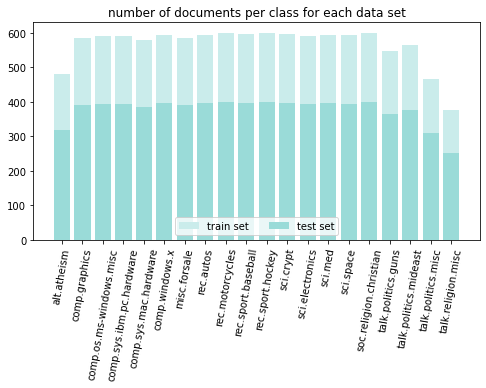

In [5]:
plot_labels([train_df['target'], test_df['target']], ['train set', 'test set'], news_train.target_names)

### predictor variable

The predictor variable contains texts of newsgroup documents that was posted to each topic.

Below is a quick view of selected examples and frequency distribution of number of words for each text.

In [6]:
train_df.head()

,target,target_name,content
0,7,rec.autos,"I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail."
1,4,comp.sys.mac.hardware,"A fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top speed attained, CPU rated speed,\nadd on cards and adapters, heat sinks, hour of usage per day, floppy disk\nfunctionality with 800 and 1.4 m floppies are especially requested.\n\nI will be summarizing in the next two days, so please add to the network\nknowledge base if you have done the clock upgrade and haven't answered this\npoll. Thanks."
2,4,comp.sys.mac.hardware,"well folks, my mac plus finally gave up the ghost this weekend after\nstarting life as a 512k way back in 1985. sooo, i'm in the market for a\nnew machine a bit sooner than i intended to be...\n\ni'm looking into picking up a powerbook 160 or maybe 180 and have a bunch\nof questions that (hopefully) somebody can answer:\n\n* does anybody know any dirt on when the next round of powerbook\nintroductions are expected? i'd heard the 185c was supposed to make an\nappearence ""this summer"" but haven't heard anymore on it - and since i\ndon't have access to macleak, i was wondering if anybody out there had\nmore info...\n\n* has anybody heard rumors about price drops to the powerbook line like the\nones the duo's just went through recently?\n\n* what's the impression of the display on the 180? i could probably swing\na 180 if i got the 80Mb disk rather than the 120, but i don't really have\na feel for how much ""better"" the display is (yea, it looks great in the\nstore, but is that all ""..."
3,1,comp.graphics,\nDo you have Weitek's address/phone number? I'd like to get some information\nabout this chip.\n
4,14,sci.space,"From article <C5owCB.n3p@world.std.com>, by tombaker@world.std.com (Tom A Baker):\n\n\nMy understanding is that the 'expected errors' are basically\nknown bugs in the warning system software - things are checked\nthat don't have the right values in yet because they aren't\nset till after launch, and suchlike. Rather than fix the code\nand possibly introduce new bugs, they just tell the crew\n'ok, if you see a warning no. 213 before liftoff, ignore it'."


In [7]:
print(train_df['target_name'][9999])
print(train_df['content'][9999])

comp.sys.ibm.pc.hardware


If you bought your IDE drive from a dealer, you shouldn 't have to 
perform a low level format. Even if the 1st HD is already partitioned
into C and D, FDISK will automatically assign the 2 nd HD to D and 
change the 2nd partition of 1st drive to E.


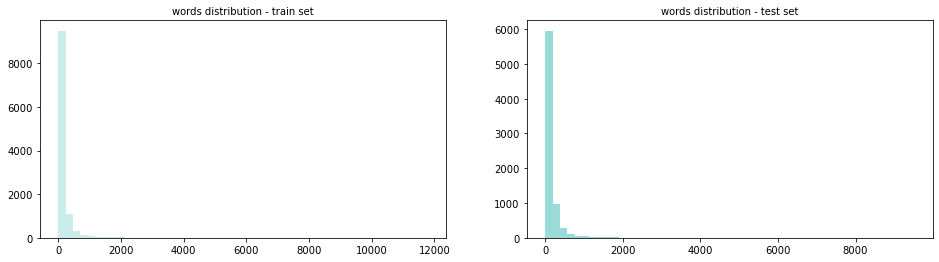

In [8]:
plot_words([train_df['content'], test_df['content']], ['train set', 'test set'])

Statistics of text length in each data set:

In [9]:
train_df['word_counts'] = word_counts(train_df, 'content')
test_df['word_counts'] = word_counts(test_df, 'content')

pd.concat([train_df['word_counts'].describe(), test_df['word_counts'].describe()], axis=1,
          keys=['training set', 'test set'])

,training set,test set
count,11314.000000,7532.000000
mean,185.827382,175.344397
std,523.971647,465.226887
min,0.000000,0.000000
25%,40.000000,39.000000
50%,83.000000,82.000000
75%,167.000000,163.000000
max,11765.000000,9507.000000


There are some documents where there are no text at all (the number of words is 0).
Those rows will be dropped in the next step.

## 3. Data preprocessing

### cleaning text data

Text cleaning includes: normalizing text, removing unicode characters and numbers, removing english stopwords and performing stemming

In [10]:
train_df['cleaned_content'] = clean_text(train_df['content'], stopwords.words('english'))
test_df['cleaned_content'] = clean_text(test_df['content'], stopwords.words('english'))

In [11]:
train_df.head(3)

,target,target_name,content,word_counts,cleaned_content
0,7,rec.autos,"I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.",91,i wonder anyon could enlighten car i saw day it door sport car look late earli it call bricklin the door realli small in addit front bumper separ rest bodi thi i know if anyon tellm model name engin spec year product car made histori whatev info funki look car pleas e mail
1,4,comp.sys.mac.hardware,"A fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top speed attained, CPU rated speed,\nadd on cards and adapters, heat sinks, hour of usage per day, floppy disk\nfunctionality with 800 and 1.4 m floppies are especially requested.\n\nI will be summarizing in the next two days, so please add to the network\nknowledge base if you have done the clock upgrade and haven't answered this\npoll. Thanks.",90,a fair number brave soul upgrad si clock oscil share experi poll pleas send brief messag detail experi procedur top speed attain cpu rate speed add card adapt heat sink hour usag per day floppi disk function floppi especi request i summar next two day pleas add network knowledg base done clock upgrad answer poll thank
2,4,comp.sys.mac.hardware,"well folks, my mac plus finally gave up the ghost this weekend after\nstarting life as a 512k way back in 1985. sooo, i'm in the market for a\nnew machine a bit sooner than i intended to be...\n\ni'm looking into picking up a powerbook 160 or maybe 180 and have a bunch\nof questions that (hopefully) somebody can answer:\n\n* does anybody know any dirt on when the next round of powerbook\nintroductions are expected? i'd heard the 185c was supposed to make an\nappearence ""this summer"" but haven't heard anymore on it - and since i\ndon't have access to macleak, i was wondering if anybody out there had\nmore info...\n\n* has anybody heard rumors about price drops to the powerbook line like the\nones the duo's just went through recently?\n\n* what's the impression of the display on the 180? i could probably swing\na 180 if i got the 80Mb disk rather than the 120, but i don't really have\na feel for how much ""better"" the display is (yea, it looks great in the\nstore, but is that all ""...",307,well folk mac plu final gave ghost weekend start life k way back sooo market new machin bit sooner intend look pick powerbook mayb bunch question hope somebodi answer anybodi know dirt next round powerbook introduct expect heard c suppos make appear summer heard anymor sinc access macleak wonder anybodi info anybodi heard rumor price drop powerbook line like one duo went recent impress display could probabl swing got mb disk rather realli feel much better display yea look great store wow realli good could solicit opinion peopl use day day worth take disk size money hit get activ display realiz real subject question play around machin comput store breifli figur opinion somebodi actual use machin daili might prove help well hellcat perform thank bunch advanc info could email post summari news read time premium final around corner tom willi twilli ecn purdu edu purdu electr engin


### removing documents without text

In [12]:
train_df['cleaned_word_counts'] = word_counts(train_df, 'cleaned_content')
test_df['cleaned_word_counts'] = word_counts(test_df, 'cleaned_content')

In [13]:
train_df[train_df['cleaned_word_counts']==0]

,target,target_name,content,word_counts,cleaned_content,cleaned_word_counts
12,4,comp.sys.mac.hardware,--\n,1,,0
155,4,comp.sys.mac.hardware,,0,,0
164,9,rec.sport.baseball,,0,,0
171,1,comp.graphics,,0,,0
205,14,sci.space,,0,,0
...,...,...,...,...,...,...
11058,5,comp.windows.x,,0,,0
11079,14,sci.space,,0,,0
11238,7,rec.autos,,0,,0
11304,19,talk.religion.misc,,0,,0


In [14]:
print('number of empty documents in train set:', len(train_df[train_df['cleaned_word_counts']==0]))
print('number of empty documents in test  set:', len(test_df[test_df['cleaned_word_counts']==0]))

number of empty documents in train set: 312
number of empty documents in test  set: 226


In [15]:
train_df = drop_empty(train_df, 'cleaned_word_counts')
test_df = drop_empty(test_df, 'cleaned_word_counts')

Statistics of text length in each data set after cleaning and removing empty documents:

In [16]:
pd.concat([train_df['cleaned_word_counts'].describe(), test_df['cleaned_word_counts'].describe()], axis=1,
          keys=['training set', 'test set'])

,training set,test set
count,11002.000000,7306.000000
mean,133.955917,112.460170
std,642.222159,553.521884
min,1.000000,1.000000
25%,26.000000,25.000000
50%,51.000000,50.000000
75%,99.000000,96.000000
max,15494.000000,38583.000000


## 4. Creating x and y variables

In [17]:
x_train = train_df['cleaned_content']
x_test = test_df['cleaned_content']
y_train = train_df['target']
y_test = test_df['target']

In [18]:
x_train.shape, y_train.shape

((11002,), (11002,))

### preparing data for machine learning models: tf-idf vectorizer

In [19]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.5, min_df=5, ngram_range = (1,2))

x_train_tfidf = tfidf_vectorizer.fit_transform(x_train).todense()
x_test_tfidf = tfidf_vectorizer.transform(x_test).todense()

### balance the dataset

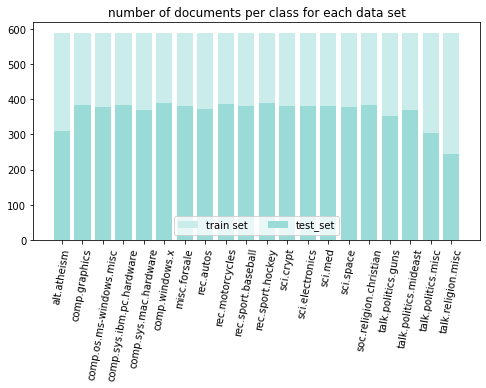

In [20]:
smote = SMOTE(random_state = RANDOM_STATE)
x_train_smote, y_train_smote = smote.fit_resample(x_train_tfidf, y_train)
plot_labels([y_train_smote, y_test], ['train set', 'test_set'], news_train.target_names)

### preparing data for machine learning models: splitting data to train and validation set

In [21]:
y_train_ohs = to_categorical(y_train_smote, num_classes=num_classes)
x_train_nn, x_valid_nn, y_train_nn, y_valid_nn = train_test_split(x_train_smote, y_train_ohs,
                                                                  test_size=0.2,
                                                                  random_state=RANDOM_STATE,
                                                                  stratify=y_train_ohs)

### preparing data for RNN: data tokenization

In order to create RNN model there is need to do tokenization (generate sequence of n-grams) and padding (make all the documents have same length)

Size of vocabulary is set to 15 000 most common words.

Content length is set to 500 words (for speed purposes).


In [22]:
num_words = 15000
maxlen = 500

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(x_train)

x_train_tk = tokenizer.texts_to_sequences(x_train)
x_train_tk = pad_sequences(x_train_tk, maxlen=maxlen)

x_test_tk  = tokenizer.texts_to_sequences(x_test)
x_test_tk  = pad_sequences(x_test_tk, maxlen=maxlen)

In [23]:
word_index = tokenizer.word_index
print('number of unique words:', len(word_index))

number of unique words: 55522


Content is now converted to sequences of numbers with equal length

In [24]:
print('length:', len(x_train_tk[0]))
print(x_train_tk[0])

length: 500
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0   

### balance the dataset

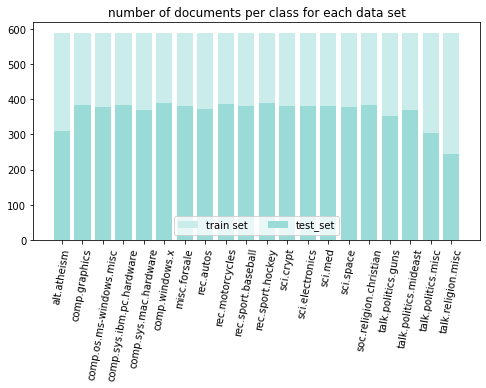

In [25]:
smote = SMOTE(random_state = RANDOM_STATE)
x_train_tks, y_train_s = smote.fit_resample(x_train_tk, y_train)
plot_labels([y_train_s, y_test], ['train set', 'test_set'], news_train.target_names)

### preparing data for RNN: one hot encoding

In [26]:
y_train_oh = to_categorical(y_train_s, num_classes=num_classes)
y_test_oh = to_categorical(y_test, num_classes=num_classes)

### preparing data for RNN: splitting data to train and validation set

In [27]:
x_train_rnn, x_valid_rnn, y_train_rnn, y_valid_rnn = train_test_split(x_train_tks, y_train_oh,
                                                                      test_size=0.2,
                                                                      random_state=RANDOM_STATE,
                                                                      stratify=y_train_oh)

There is difference between data prepared for machine learning models like e.g. logistic regression and recurrent neural network models so in order to avoid confusion names of variables was changed

In [28]:
x_train_ml, y_train_ml = x_train_smote, y_train_smote
x_test_ml, y_test_ml = x_test_tfidf, y_test
x_test_rnn, y_test_rnn = x_test_tk, y_test_oh

In [29]:
print('ml train dataset shape:', x_train_ml.shape, y_train_ml.shape)
print('ml test  dataset shape:', x_test_ml.shape, y_test_ml.shape)
print('rnn train dataset shape:', x_train_rnn.shape, y_train_rnn.shape)
print('rnn valid dataset shape: ', x_valid_rnn.shape, y_valid_rnn.shape)
print('rnn test  dataset shape: ', x_test_rnn.shape, y_test_rnn.shape)

ml train dataset shape: (11800, 32220) (11800,)
ml test  dataset shape: (7306, 32220) (7306,)
rnn train dataset shape: (9440, 500) (9440, 20)
rnn valid dataset shape:  (2360, 500) (2360, 20)
rnn test  dataset shape:  (7306, 500) (7306, 20)


## 5. Embeddings

### gensim word2vec model

In [30]:
embedding_dim = 100
vocabulary_size = min(num_words, len(word_index))

Training word2vec model based on train data:

In [31]:
neighbor_words_num = 6
epochs = 100

sentences = [x.split() for x in x_train]
w2v_model = Word2Vec(sentences,
                     vector_size=embedding_dim,
                     window=neighbor_words_num,
                     epochs=epochs,
                     min_count=1,
                     sg=1)

In [32]:
w2v_model.save("w2v_model.model")
print('model saved')
# w2v_model = Word2Vec.load('w2v_model.model')
# print('model loaded')

model saved


Visualizing word embeddings using t-sne to see similarity between objects:

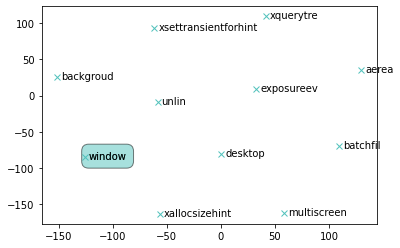

In [33]:
tsne_word_plot(w2v_model, 'window', embedding_dim)

Creating the embedding layer:

In [34]:
embedding_matrix = np.zeros((vocabulary_size, embedding_dim))
for word, index in word_index.items():
    if index > vocabulary_size:
        continue
    elif word in w2v_model.wv:
        embedding_matrix[index-1] = w2v_model.wv[word]

In [35]:
embedding_matrix[word_index['computer']]

array([-0.14130524, -0.3351602 ,  0.07343651,  0.13777043, -0.79080981,
       -0.09989693,  0.08482552,  0.16490927,  0.58801097,  0.39631093,
        0.15735365, -0.45571053, -0.61874527,  0.289     , -0.59302074,
       -0.87221068, -0.84416175,  0.12663558,  0.96405905,  0.17455287,
        0.02495161,  0.66226256,  0.41279903,  1.3103981 ,  0.43521395,
       -0.41188937, -0.42045727,  0.92221677,  0.65001357,  0.49539942,
        0.12141994,  0.25506851,  0.49200073, -0.60792136,  0.08814327,
        0.93585503, -0.05491179, -0.59432596,  0.72961807, -0.39651692,
       -0.86499256,  1.08457744,  0.11974362, -0.61094874,  0.58546203,
        0.30458286,  0.1936326 ,  0.34589276,  0.34792048,  0.0435791 ,
       -0.40658712, -0.17921995,  0.22556537, -0.55352396,  0.37481502,
       -0.76734632,  1.0374645 , -0.8502472 , -0.64049202,  0.79527873,
       -0.43143967, -0.32110059, -0.17861241,  0.23307492, -0.06783054,
        0.65084976, -0.52073896,  0.06316039,  0.39068636,  0.11

In [36]:
print('number of word vectors: ', len(embedding_matrix))

number of word vectors:  15000


Similarity between objects:

In [37]:
print(np.linalg.norm(embedding_matrix[word_index['man']] - embedding_matrix[word_index['woman']]))
print(np.linalg.norm(embedding_matrix[word_index['cat']] - embedding_matrix[word_index['dog']]))

4.820322942313505
6.074166225102274


### glove model

Loading the model:

In [38]:
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

print('number of word vectors in GloVe:', len(embeddings_index))

number of word vectors in GloVe: 400000


Creating the embedding layer:

In [39]:
glove_embedding_matrix = np.zeros((vocabulary_size, embedding_dim))
for word, index in word_index.items():
    if index >= vocabulary_size:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        glove_embedding_matrix[index-1] = embedding_vector

In [40]:
glove_embedding_matrix[word_index['computer']]

array([-0.050144  , -0.30862999, -0.019044  ,  0.3994    , -0.13455001,
       -0.095894  ,  0.056637  , -0.29846001,  0.033447  , -0.22065   ,
        0.13608   , -0.19844   ,  0.26367   ,  0.57896   ,  0.074624  ,
        0.13513   , -0.36596   ,  0.018138  , -0.33013999, -0.18419001,
       -0.13022999, -0.12357   ,  0.045459  ,  0.054871  ,  0.31314   ,
       -0.013239  , -0.010086  , -0.12916   ,  0.26631999,  0.21287   ,
        0.38951999, -0.13948999, -0.1602    ,  0.28738999, -0.22147   ,
       -0.08575   ,  0.11342   , -0.33862999, -0.19961999,  0.1468    ,
        0.31588   ,  0.033843  , -0.068868  ,  0.24939001, -0.25975999,
        0.18592   ,  0.34575999,  0.28922999, -0.021273  ,  0.24684   ,
       -0.071011  ,  0.29649001, -0.022333  , -0.19017   , -0.28608   ,
        0.76786   ,  0.17952999,  0.29407001, -0.18651   , -0.50182998,
        0.047334  , -0.43768999,  0.31163001, -0.23208   , -0.25536001,
        0.21636   ,  0.17493001,  0.075736  , -0.65139002, -0.32

In [41]:
print('number of word vectors: ', len(glove_embedding_matrix))

number of word vectors:  15000


Similarity between objects:

In [42]:
print(np.linalg.norm(embeddings_index['man'] - embeddings_index['woman']))
print(np.linalg.norm(embeddings_index['cat'] - embeddings_index['dog']))

3.364068
2.681131


## 4. Models: neural network

#### model 1: RNN + embeddings from trained word2vec model

In [43]:
emb = Embedding(input_dim=vocabulary_size,
                output_dim=embedding_dim,
                weights=[embedding_matrix],
                input_length=maxlen,
                trainable=False)

model1 = Sequential(name="model_1")
model1.add(emb)
model1.add(LSTM(24, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model1.add(LSTM(24, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
model1.add(Dense(24, activation = 'relu'))
model1.add(Dense(num_classes, activation='softmax'))
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
model1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 100)          1500000   
_________________________________________________________________
lstm (LSTM)                  (None, 500, 24)           12000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 24)                4704      
_________________________________________________________________
dense (Dense)                (None, 24)                600       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                500       
Total params: 1,517,804
Trainable params: 17,804
Non-trainable params: 1,500,000
_________________________________________________________________


In [44]:
epochs = 300
batch_size = 100
history = model_fit(model1, x_train_rnn, y_train_rnn, x_valid_rnn, y_valid_rnn, epochs, batch_size)

Epoch 1/300
95/95 [==============================] - ETA: 0s - loss: 2.9931 - categorical_accuracy: 0.0503
Epoch 00001: val_categorical_accuracy improved from -inf to 0.06398, saving model to model_1_weights.hdf5
95/95 [==============================] - 113s 1s/step - loss: 2.9931 - categorical_accuracy: 0.0503 - val_loss: 2.9817 - val_categorical_accuracy: 0.0640
Epoch 2/300
95/95 [==============================] - ETA: 0s - loss: 2.9642 - categorical_accuracy: 0.0738
Epoch 00002: val_categorical_accuracy improved from 0.06398 to 0.08305, saving model to model_1_weights.hdf5
95/95 [==============================] - 119s 1s/step - loss: 2.9642 - categorical_accuracy: 0.0738 - val_loss: 2.9461 - val_categorical_accuracy: 0.0831
Epoch 3/300
95/95 [==============================] - ETA: 0s - loss: 2.9117 - categorical_accuracy: 0.0941
Epoch 00003: val_categorical_accuracy improved from 0.08305 to 0.09576, saving model to model_1_weights.hdf5
95/95 [==============================] - 127s 1

Epoch 24/300
95/95 [==============================] - ETA: 0s - loss: 2.1983 - categorical_accuracy: 0.2917
Epoch 00024: val_categorical_accuracy improved from 0.26059 to 0.26441, saving model to model_1_weights.hdf5
95/95 [==============================] - 125s 1s/step - loss: 2.1983 - categorical_accuracy: 0.2917 - val_loss: 2.3167 - val_categorical_accuracy: 0.2644
Epoch 25/300
95/95 [==============================] - ETA: 0s - loss: 2.1907 - categorical_accuracy: 0.2988
Epoch 00025: val_categorical_accuracy improved from 0.26441 to 0.29619, saving model to model_1_weights.hdf5
95/95 [==============================] - 125s 1s/step - loss: 2.1907 - categorical_accuracy: 0.2988 - val_loss: 2.2247 - val_categorical_accuracy: 0.2962
Epoch 26/300
95/95 [==============================] - ETA: 0s - loss: 2.1502 - categorical_accuracy: 0.3053
Epoch 00026: val_categorical_accuracy did not improve from 0.29619
95/95 [==============================] - 122s 1s/step - loss: 2.1502 - categorical_

Epoch 48/300
95/95 [==============================] - ETA: 0s - loss: 1.8749 - categorical_accuracy: 0.3983
Epoch 00048: val_categorical_accuracy did not improve from 0.36483
95/95 [==============================] - 116s 1s/step - loss: 1.8749 - categorical_accuracy: 0.3983 - val_loss: 2.0230 - val_categorical_accuracy: 0.3581
Epoch 49/300
95/95 [==============================] - ETA: 0s - loss: 1.8748 - categorical_accuracy: 0.3916
Epoch 00049: val_categorical_accuracy improved from 0.36483 to 0.36907, saving model to model_1_weights.hdf5
95/95 [==============================] - 117s 1s/step - loss: 1.8748 - categorical_accuracy: 0.3916 - val_loss: 1.9699 - val_categorical_accuracy: 0.3691
Epoch 50/300
95/95 [==============================] - ETA: 0s - loss: 1.8520 - categorical_accuracy: 0.4020
Epoch 00050: val_categorical_accuracy did not improve from 0.36907
95/95 [==============================] - 116s 1s/step - loss: 1.8520 - categorical_accuracy: 0.4020 - val_loss: 1.9660 - val_

95/95 [==============================] - ETA: 0s - loss: 1.7323 - categorical_accuracy: 0.4399
Epoch 00072: val_categorical_accuracy did not improve from 0.40678
95/95 [==============================] - 105s 1s/step - loss: 1.7323 - categorical_accuracy: 0.4399 - val_loss: 1.8754 - val_categorical_accuracy: 0.4038
Epoch 73/300
95/95 [==============================] - ETA: 0s - loss: 1.7087 - categorical_accuracy: 0.4480
Epoch 00073: val_categorical_accuracy improved from 0.40678 to 0.40720, saving model to model_1_weights.hdf5
95/95 [==============================] - 105s 1s/step - loss: 1.7087 - categorical_accuracy: 0.4480 - val_loss: 1.8761 - val_categorical_accuracy: 0.4072
Epoch 74/300
95/95 [==============================] - ETA: 0s - loss: 1.7141 - categorical_accuracy: 0.4462
Epoch 00074: val_categorical_accuracy did not improve from 0.40720
95/95 [==============================] - 105s 1s/step - loss: 1.7141 - categorical_accuracy: 0.4462 - val_loss: 1.8708 - val_categorical_a

95/95 [==============================] - ETA: 0s - loss: 1.6131 - categorical_accuracy: 0.4787
Epoch 00096: val_categorical_accuracy did not improve from 0.44534
95/95 [==============================] - 107s 1s/step - loss: 1.6131 - categorical_accuracy: 0.4787 - val_loss: 1.8328 - val_categorical_accuracy: 0.4292
Epoch 97/300
95/95 [==============================] - ETA: 0s - loss: 1.6086 - categorical_accuracy: 0.4803
Epoch 00097: val_categorical_accuracy did not improve from 0.44534
95/95 [==============================] - 108s 1s/step - loss: 1.6086 - categorical_accuracy: 0.4803 - val_loss: 1.7872 - val_categorical_accuracy: 0.4453
Epoch 98/300
95/95 [==============================] - ETA: 0s - loss: 1.6102 - categorical_accuracy: 0.4855
Epoch 00098: val_categorical_accuracy did not improve from 0.44534
95/95 [==============================] - 108s 1s/step - loss: 1.6102 - categorical_accuracy: 0.4855 - val_loss: 1.8016 - val_categorical_accuracy: 0.4403
Epoch 99/300
95/95 [======

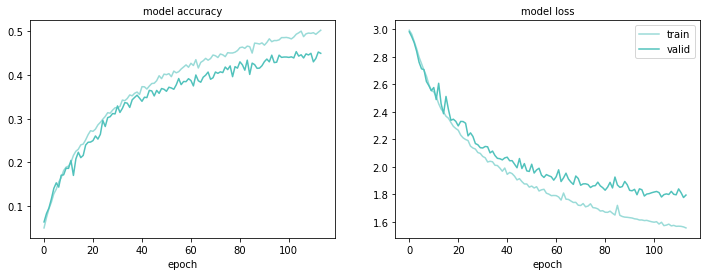

229/229 [==============================] - 19s 85ms/step - loss: 1.8707 - categorical_accuracy: 0.4187

-----------------------
model_1 
loss: 1.8707401752471924 
accuracy: 0.41869696974754333
-----------------------


In [45]:
m1_y_pred, m1_acc = model_eval(model1, history, x_test_rnn, y_test_rnn)

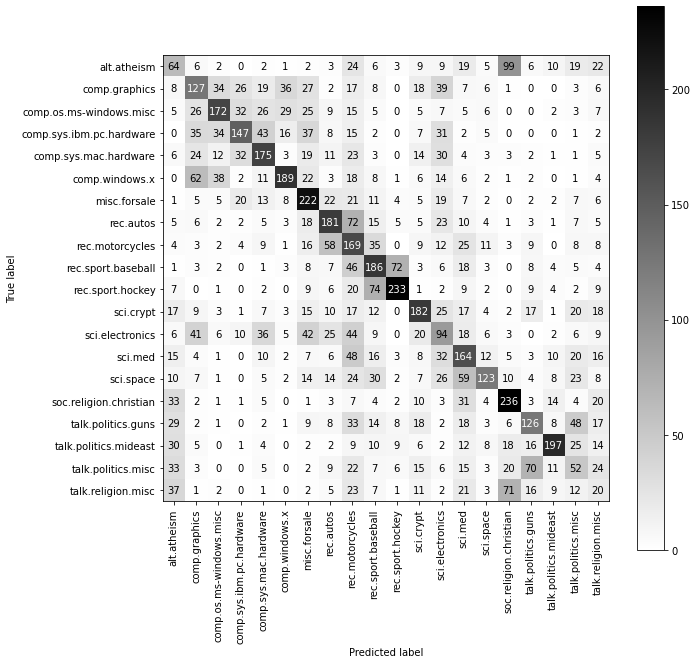

,precision,recall,f1-score,support
alt.atheism,0.205788,0.205788,0.205788,311.000000
comp.graphics,0.342318,0.330729,0.336424,384.000000
comp.os.ms-windows.misc,0.539185,0.453826,0.492837,379.000000
comp.sys.ibm.pc.hardware,0.528777,0.381818,0.443439,385.000000
comp.sys.mac.hardware,0.459318,0.471698,0.465426,371.000000
comp.windows.x,0.625828,0.484615,0.546243,390.000000
misc.forsale,0.444890,0.581152,0.503973,382.000000
rec.autos,0.461735,0.485255,0.473203,373.000000
rec.motorcycles,0.253373,0.437824,0.320988,386.000000
rec.sport.baseball,0.402597,0.489474,0.441805,380.000000


In [46]:
model_report(y_test, m1_y_pred, news_train.target_names)

In [47]:
# loading the best weights
# model1.load_weights("m1_weights.hdf5")

#### model 2: RNN + glove embeddings

In [48]:
emb = Embedding(input_dim=vocabulary_size,
                output_dim=embedding_dim,
                weights=[glove_embedding_matrix],
                input_length=maxlen,
                trainable=False)

model2 = Sequential(name="model_2")
model2.add(emb)
model2.add(LSTM(24, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model2.add(LSTM(24, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
model2.add(Dense(24, activation = 'relu'))
model2.add(Dense(num_classes, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
model2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          1500000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 500, 24)           12000     
_________________________________________________________________
lstm_3 (LSTM)                (None, 24)                4704      
_________________________________________________________________
dense_2 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_3 (Dense)              (None, 20)                500       
Total params: 1,517,804
Trainable params: 17,804
Non-trainable params: 1,500,000
_________________________________________________________________


In [49]:
epochs = 300
batch_size = 100
history = model_fit(model2, x_train_rnn, y_train_rnn, x_valid_rnn, y_valid_rnn, epochs, batch_size)

Epoch 1/300
95/95 [==============================] - ETA: 0s - loss: 2.9942 - categorical_accuracy: 0.0528
Epoch 00001: val_categorical_accuracy improved from -inf to 0.05847, saving model to model_2_weights.hdf5
95/95 [==============================] - 125s 1s/step - loss: 2.9942 - categorical_accuracy: 0.0528 - val_loss: 2.9860 - val_categorical_accuracy: 0.0585
Epoch 2/300
95/95 [==============================] - ETA: 0s - loss: 2.9780 - categorical_accuracy: 0.0662
Epoch 00002: val_categorical_accuracy improved from 0.05847 to 0.07627, saving model to model_2_weights.hdf5
95/95 [==============================] - 125s 1s/step - loss: 2.9780 - categorical_accuracy: 0.0662 - val_loss: 2.9683 - val_categorical_accuracy: 0.0763
Epoch 3/300
95/95 [==============================] - ETA: 0s - loss: 2.9422 - categorical_accuracy: 0.0874
Epoch 00003: val_categorical_accuracy did not improve from 0.07627
95/95 [==============================] - 125s 1s/step - loss: 2.9422 - categorical_accura

Epoch 24/300
95/95 [==============================] - ETA: 0s - loss: 2.2893 - categorical_accuracy: 0.2519
Epoch 00024: val_categorical_accuracy improved from 0.24195 to 0.25339, saving model to model_2_weights.hdf5
95/95 [==============================] - 126s 1s/step - loss: 2.2893 - categorical_accuracy: 0.2519 - val_loss: 2.3222 - val_categorical_accuracy: 0.2534
Epoch 25/300
95/95 [==============================] - ETA: 0s - loss: 2.2445 - categorical_accuracy: 0.2601
Epoch 00025: val_categorical_accuracy improved from 0.25339 to 0.25975, saving model to model_2_weights.hdf5
95/95 [==============================] - 127s 1s/step - loss: 2.2445 - categorical_accuracy: 0.2601 - val_loss: 2.3106 - val_categorical_accuracy: 0.2597
Epoch 26/300
95/95 [==============================] - ETA: 0s - loss: 2.2237 - categorical_accuracy: 0.2714
Epoch 00026: val_categorical_accuracy did not improve from 0.25975
95/95 [==============================] - 126s 1s/step - loss: 2.2237 - categorical_

Epoch 48/300
95/95 [==============================] - ETA: 0s - loss: 1.9332 - categorical_accuracy: 0.3635
Epoch 00048: val_categorical_accuracy improved from 0.32627 to 0.33390, saving model to model_2_weights.hdf5
95/95 [==============================] - 129s 1s/step - loss: 1.9332 - categorical_accuracy: 0.3635 - val_loss: 2.0943 - val_categorical_accuracy: 0.3339
Epoch 49/300
95/95 [==============================] - ETA: 0s - loss: 1.9387 - categorical_accuracy: 0.3623
Epoch 00049: val_categorical_accuracy did not improve from 0.33390
95/95 [==============================] - 129s 1s/step - loss: 1.9387 - categorical_accuracy: 0.3623 - val_loss: 2.0989 - val_categorical_accuracy: 0.3339
Epoch 50/300
95/95 [==============================] - ETA: 0s - loss: 1.9262 - categorical_accuracy: 0.3641
Epoch 00050: val_categorical_accuracy improved from 0.33390 to 0.33814, saving model to model_2_weights.hdf5
95/95 [==============================] - 129s 1s/step - loss: 1.9262 - categorical_

Epoch 72/300
95/95 [==============================] - ETA: 0s - loss: 1.7597 - categorical_accuracy: 0.4195
Epoch 00072: val_categorical_accuracy improved from 0.37119 to 0.37246, saving model to model_2_weights.hdf5
95/95 [==============================] - 136s 1s/step - loss: 1.7597 - categorical_accuracy: 0.4195 - val_loss: 2.0031 - val_categorical_accuracy: 0.3725
Epoch 73/300
95/95 [==============================] - ETA: 0s - loss: 1.7432 - categorical_accuracy: 0.4219
Epoch 00073: val_categorical_accuracy did not improve from 0.37246
95/95 [==============================] - 135s 1s/step - loss: 1.7432 - categorical_accuracy: 0.4219 - val_loss: 1.9949 - val_categorical_accuracy: 0.3695
Epoch 74/300
95/95 [==============================] - ETA: 0s - loss: 1.7428 - categorical_accuracy: 0.4226
Epoch 00074: val_categorical_accuracy improved from 0.37246 to 0.37712, saving model to model_2_weights.hdf5
95/95 [==============================] - 137s 1s/step - loss: 1.7428 - categorical_

Epoch 96/300
95/95 [==============================] - ETA: 0s - loss: 1.6372 - categorical_accuracy: 0.4615
Epoch 00096: val_categorical_accuracy did not improve from 0.41186
95/95 [==============================] - 136s 1s/step - loss: 1.6372 - categorical_accuracy: 0.4615 - val_loss: 1.9384 - val_categorical_accuracy: 0.4034
Epoch 97/300
95/95 [==============================] - ETA: 0s - loss: 1.6334 - categorical_accuracy: 0.4644
Epoch 00097: val_categorical_accuracy did not improve from 0.41186
95/95 [==============================] - 137s 1s/step - loss: 1.6334 - categorical_accuracy: 0.4644 - val_loss: 1.9206 - val_categorical_accuracy: 0.4042
Epoch 98/300
95/95 [==============================] - ETA: 0s - loss: 1.6125 - categorical_accuracy: 0.4644
Epoch 00098: val_categorical_accuracy did not improve from 0.41186
95/95 [==============================] - 136s 1s/step - loss: 1.6125 - categorical_accuracy: 0.4644 - val_loss: 1.9357 - val_categorical_accuracy: 0.3983
Epoch 99/300


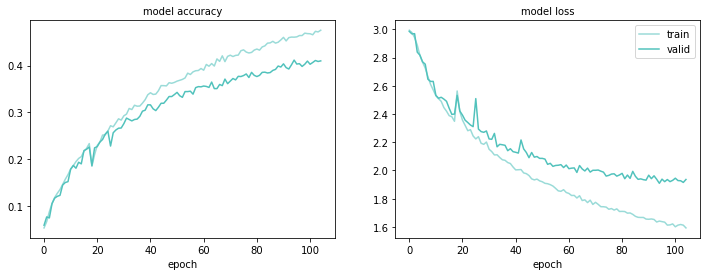

229/229 [==============================] - 21s 94ms/step - loss: 1.9577 - categorical_accuracy: 0.3869

-----------------------
model_2 
loss: 1.95773184299469 
accuracy: 0.3869422376155853
-----------------------


In [50]:
m2_y_pred, m2_acc = model_eval(model2, history, x_test_rnn, y_test_rnn)

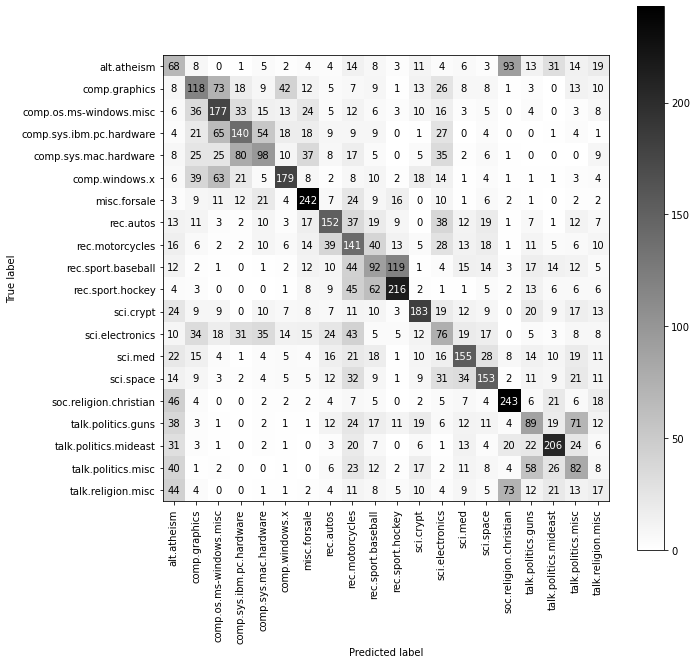

,precision,recall,f1-score,support
alt.atheism,0.163070,0.218650,0.186813,311.000000
comp.graphics,0.327778,0.307292,0.317204,384.000000
comp.os.ms-windows.misc,0.386463,0.467018,0.422939,379.000000
comp.sys.ibm.pc.hardware,0.408163,0.363636,0.384615,385.000000
comp.sys.mac.hardware,0.340278,0.264151,0.297420,371.000000
comp.windows.x,0.564669,0.458974,0.506365,390.000000
misc.forsale,0.558891,0.633508,0.593865,382.000000
rec.autos,0.449704,0.407507,0.427567,373.000000
rec.motorcycles,0.256364,0.365285,0.301282,386.000000
rec.sport.baseball,0.255556,0.242105,0.248649,380.000000


In [51]:
model_report(y_test, m2_y_pred, news_train.target_names)

#### model 3: simple dense model + tf-idf

In [52]:
model3 = Sequential(name="model_3")
model3.add(Dense(1500, input_dim=x_train_ml.shape[1], activation='relu'))
model3.add(Dense(20, activation='softmax'))

model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
model3.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1500)              48331500  
_________________________________________________________________
dense_5 (Dense)              (None, 20)                30020     
Total params: 48,361,520
Trainable params: 48,361,520
Non-trainable params: 0
_________________________________________________________________


In [53]:
epochs = 150
batch_size = 100
history = model_fit(model3, x_train_nn, y_train_nn, x_valid_nn, y_valid_nn, epochs, batch_size)

Epoch 1/150
95/95 [==============================] - ETA: 0s - loss: 1.8784 - categorical_accuracy: 0.6520
Epoch 00001: val_categorical_accuracy improved from -inf to 0.80127, saving model to model_3_weights.hdf5
95/95 [==============================] - 47s 493ms/step - loss: 1.8784 - categorical_accuracy: 0.6520 - val_loss: 0.9205 - val_categorical_accuracy: 0.8013
Epoch 2/150
95/95 [==============================] - ETA: 0s - loss: 0.3463 - categorical_accuracy: 0.9463
Epoch 00002: val_categorical_accuracy improved from 0.80127 to 0.81780, saving model to model_3_weights.hdf5
95/95 [==============================] - 46s 487ms/step - loss: 0.3463 - categorical_accuracy: 0.9463 - val_loss: 0.6832 - val_categorical_accuracy: 0.8178
Epoch 3/150
95/95 [==============================] - ETA: 0s - loss: 0.0754 - categorical_accuracy: 0.9934
Epoch 00003: val_categorical_accuracy did not improve from 0.81780
95/95 [==============================] - 44s 460ms/step - loss: 0.0754 - categorical_

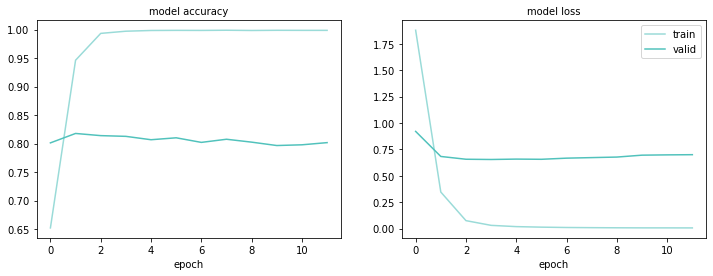

229/229 [==============================] - 22s 98ms/step - loss: 0.9949 - categorical_accuracy: 0.7158

-----------------------
model_3 
loss: 0.9949452877044678 
accuracy: 0.7158499956130981
-----------------------


In [54]:
m3_y_pred, m3_acc = model_eval(model3, history, x_test_ml, y_test_rnn)

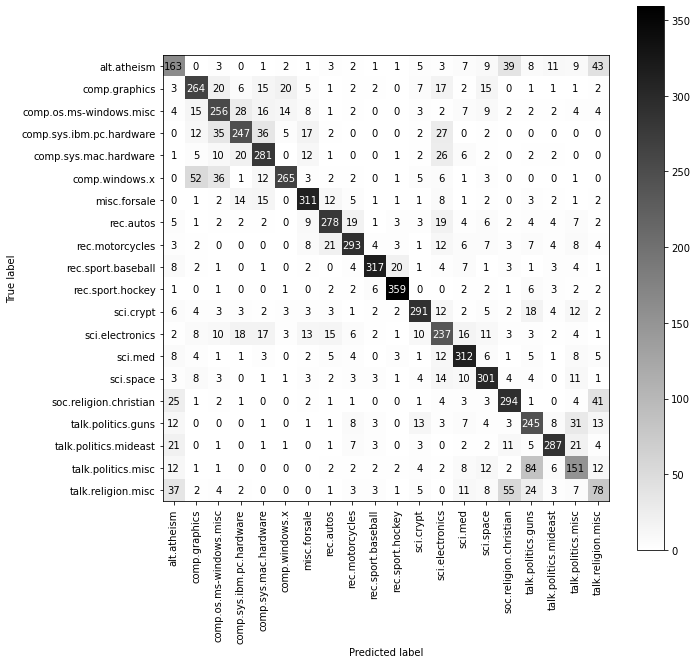

,precision,recall,f1-score,support
alt.atheism,0.519108,0.524116,0.521600,311.00000
comp.graphics,0.691099,0.687500,0.689295,384.00000
comp.os.ms-windows.misc,0.654731,0.675462,0.664935,379.00000
comp.sys.ibm.pc.hardware,0.720117,0.641558,0.678571,385.00000
comp.sys.mac.hardware,0.695545,0.757412,0.725161,371.00000
comp.windows.x,0.841270,0.679487,0.751773,390.00000
misc.forsale,0.777500,0.814136,0.795396,382.00000
rec.autos,0.785311,0.745308,0.764787,373.00000
rec.motorcycles,0.800546,0.759067,0.779255,386.00000
rec.sport.baseball,0.905714,0.834211,0.868493,380.00000


In [55]:
model_report(y_test, m3_y_pred, news_train.target_names)

## 5. Models: other machine learning classifiers

In [56]:
kfold = StratifiedKFold(n_splits=3)

### naive bayes

In [57]:
model_nb = MultinomialNB()
params = {'alpha':[0.01, 0.05, 0.1]}

grid_nb = GridSearchCV(model_nb, params, cv=kfold, scoring = 'accuracy')
grid_nb.fit(x_train_ml, y_train_ml)
print(grid_nb.best_params_)

{'alpha': 0.05}


In [58]:
show_model_performance(grid_nb.best_estimator_, x_train_ml, y_train_ml, x_test_ml, y_test_ml)

,precision,recall,f1,accuracy
train,0.976500,0.976400,0.976400,0.976400
test,0.713100,0.709100,0.708500,0.709100


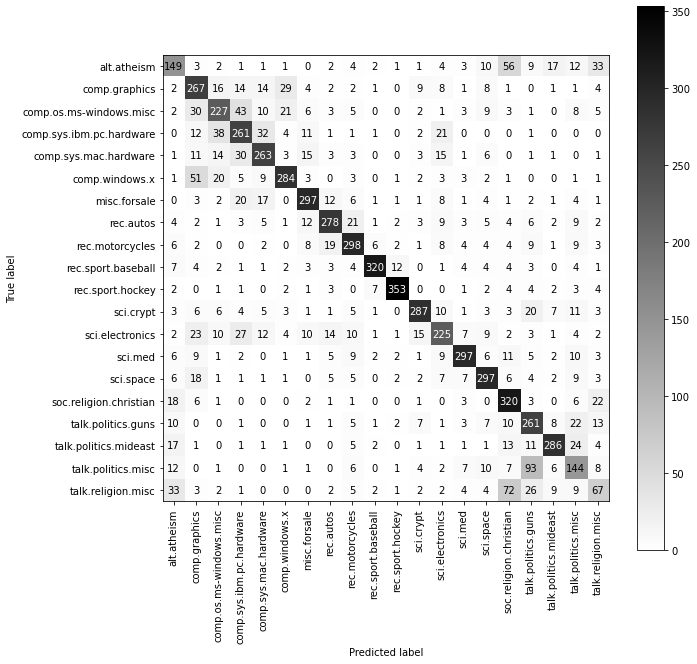

,precision,recall,f1-score,support
alt.atheism,0.530249,0.479100,0.503378,311.000000
comp.graphics,0.592018,0.695312,0.639521,384.000000
comp.os.ms-windows.misc,0.657971,0.598945,0.627072,379.000000
comp.sys.ibm.pc.hardware,0.627404,0.677922,0.651685,385.000000
comp.sys.mac.hardware,0.705094,0.708895,0.706989,371.000000
comp.windows.x,0.793296,0.728205,0.759358,390.000000
misc.forsale,0.789894,0.777487,0.783641,382.000000
rec.autos,0.783099,0.745308,0.763736,373.000000
rec.motorcycles,0.748744,0.772021,0.760204,386.000000
rec.sport.baseball,0.919540,0.842105,0.879121,380.000000


In [59]:
m4_y_pred = grid_nb.best_estimator_.predict(x_test_ml)
model_report(y_test, m4_y_pred, news_train.target_names)

### support vector machine

In [ ]:
model_svc = SVC()
params = {
    'gamma': [0.01, 0.1],
    'C': [0.01, 0.1, 1]
}

grid_svc = GridSearchCV(model_svc, params, cv=kfold, scoring = 'accuracy')
grid_svc.fit(x_train_ml, y_train_ml)
print(grid_svc.best_params_)

In [ ]:
show_model_performance(grid_svc.best_estimator_, x_train_ml, y_train_ml, x_test_ml, y_test_ml)

In [ ]:
m5_y_pred = grid_svc.best_estimator_.predict(x_test_ml)
#model_report(y_test, m5_y_pred, news_train.target_names)

### random forest

In [ ]:
model_rf = RandomForestClassifier()
params = {
    'n_estimators': [10, 50, 100],
    'min_samples_leaf': [5, 10, 20]
}

grid_rf = GridSearchCV(model_rf, params, cv=kfold, scoring = 'accuracy')
grid_rf.fit(x_train_ml, y_train_ml)
print(grid_rf.best_params_)

In [ ]:
show_model_performance(grid_rf.best_estimator_, x_train_ml, y_train_ml, x_test_ml, y_test_ml)

In [ ]:
m6_y_pred = grid_rf.best_estimator_.predict(x_test_ml)
#model_report(y_test, m6_y_pred, news_train.target_names)

## 6. Comparison of accuracy scores of different classifiers

In [ ]:
models_names = ['rnn w2w', 'rnn glove', 'dense nn', 'naive bayes', 'svm', 'random forest']
acc_values = [m1_acc, m2_acc, m3_acc, m4_acc, m5_acc, m6_acc, m7_acc]
plot_acc(models_names, acc_values


According to accuracy scores, the thrid model achieve the best result for this classification problem.

## 7. Predict group for new document

In [ ]:
news = "It's not possible for life to exist in the clouds of Venus. It's simply too dry, says an international research team led from Queen's University Belfast, UK. Hopes had been raised last year that microbes might inhabit the Venusian atmosphere, given the presence there of the gas phosphine (PH3). It was suggested the concentration could not be explained by geological activity alone. But the new Belfast study puts a dampener on this idea. The team assessed what is known about conditions in the clouds, gathered by space probes, and then looked across the library of lifeforms on Earth to see if any known organisms could persist in that challenging environment. The clouds are mostly sulphuric acid with a tiny fraction of water. The analysis concluded that the most extreme 'extremophile' - the name for microbes that live in very challenging conditions - wouldn't be able to survive, let alone thrive. 'We found not only is the effective concentration of water molecules slightly below what's needed for the most resilient microorganism on Earth, it's more than 100 times too low. It's almost at the bottom of the scale, and an unbridgeable distance from what life requires to be active,' Dr John Hallsworth from Belfast's School of Biological Sciences said. Does this 'kill' the idea of detecting life on Venus? It was certainly a thrilling and intriguing announcement when a separate team came forward last September with the tantalising observations of PH3 at the second planet from the Sun. On Earth, phosphine is associated with life, with microbes living in the guts of animals like penguins, or in oxygen-poor environments such as swamps. It's possible to make the gas industrially, but there are no factories on Venus; so its signal in the planet's clouds demanded an explanation. September's team, led by Prof Jane Greaves from Cardiff University, raised the possibility of Venusian life and invited other groups to knock down the proposition. Some astronomers initially questioned the correctness of the PH3 observations, which were made with two different telescope systems. But this latest challenge comes from a very different quarter - from experts in biochemistry. Dr Hallsworth is a microbiologist whose focus is the reaction of living organisms to stress. Prof Greaves praised his work on Monday, describing the new study as an excellent piece of work. But she still thinks there is the possibility of a liveable window in the Venusian clouds. 'We spoke about this at some length last year; we know Venus's atmosphere is extremely desiccated but what we don't know is how well mixed it is. 'A colleague, Paul Rimmer, has a paper just out showing that some cloud droplets could have a very high water content,' she told BBC News. Prof Greaves highlighted the dark streaks sometimes seen on short timescales in the atmosphere in ultraviolet light. It's been speculated that these could be microbial colonies that evolve, die out and then re-emerge. Dr Chris McKay is a leading figure in astrobiology, a field that examines the possibilities for life beyond Earth. The US space agency (Nasa) researcher, a co-author on the new Hallsworth study, said he would love to think Venus was inhabited but that the direct measurements of the atmosphere made by past probes really suggested this was unlikely. More promising - although still very difficult to prove - is the notion that life might exist in the cloud layers of Jupiter. The new research indicates compatible temperatures and water availability should be found at a depth where the pressure is about five times that at sea-level on Earth. Of course, this says nothing about the other requirements for life, such as a supply of nutrients. 'It's much harder to say a place is habitable than to say a place is not habitable, Dr McKay explained. 'To say a place is not habitable, all one has to do is show that some condition is beyond the range that life can tolerate. We've done that for Venus, unfortunately. 'We also show that one parameter - water activity - is within the range in a certain layer at Jupiter. But to show that this layer is habitable, we would have to go through all the requirements for life and show that they're all met. So it's much harder to say, Jupiter's atmosphere is habitable than it is to say Venus's clouds are uninhabitable.' Venus is the hot planetary topic of the moment. Nasa and the European Space Agency have just approved three new missions to go visit the world, starting at the end of this decade. And a private launch company, Rocket Lab, intends to send an atmospheric entry craft as soon as 2023. This has contributions from members of Prof Greaves' team and will look to sample the phosphine gas as the probe descends through the clouds. Additionally, the team is about to formally publish responses to other scientists who doubted the robustness of their telescopic observations. 'We've looked at the data again, major improvements have been made [by the staff at the Alma observatory in Chile], and I'm really happy with what we've seen at Venus,' Prof Greaves said."

predict_news_group(news, grid_nb.best_estimator_, tfidf_vectorizer)

## 8. Summary

- Results:

The best model achieves more than 70% accuracy on the test set. It is good quite good performance. It has some problems with similiar groups like: *comp.windows.x* and *comp.graphics*, *soc.religion.christian* and *talk.religion.misc* or *talk.politics.guns* and *talk.politics.misc*. The best results has for the sports groups: *rec.sport.baseball* and *rec.sport.hockey*.

- Futher development:

Labels can be combine to bigger the sub-categories: politics, sports, religion, computer, etc.

RNN models can achieve better results with different architecture, other machine learning models can be tested with bigger param grids.

- Possible usage:

Models like these can be used to assign emails in customer support centers, suggest responses, or classify other forms of text like invoices which need to be assigned to an department.